Standardized Precipitation Index (SPI) Forecasting Using LSTM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet  # optional, not used in this notebook
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import time
from scipy.stats import gamma, norm

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


c:\Users\varas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: Load and Prepare Data
#Read and preprocess the input data


In [2]:
df = pd.read_csv("../result/merged_data.csv")
df['data'] = pd.to_datetime(df['data'])
df['month'] = df['data'].dt.to_period('M')
df = df.sort_values(by=['station_id', 'data'])
df.head()
# Group by station and month, summing precipitation
monthly_precip = df.groupby(['station_id', 'month'])['rrr24'].sum().reset_index()
monthly_precip['month'] = monthly_precip['month'].dt.to_timestamp()
monthly_precip.rename(columns={'month': 'ds', 'rrr24': 'precip'}, inplace=True)
# monthly_precip.head()


C:\Users\varas\AppData\Local\Temp\ipykernel_18500\97747187.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data'] = pd.to_datetime(df['data'])


Step 2: Compute SPI (Standardized Precipitation Index)


In [3]:
def compute_spi(precip_series):
    precip_array = precip_series.values
    nonzero = precip_array[precip_array > 0]

    if len(nonzero) == 0:
        return np.full_like(precip_array, np.nan, dtype=float)

    # Fit gamma distribution to non-zero data
    shape, loc, scale_param = gamma.fit(nonzero, floc=0)

    # Zero probability
    zero_prob = (precip_array == 0).sum() / len(precip_array)

    # Compute SPI values
    spi_values = np.full_like(precip_array, np.nan, dtype=float)
    for i, val in enumerate(precip_array):
        if np.isnan(val):
            continue
        if val == 0:
            prob = zero_prob
        else:
            prob = zero_prob + (1 - zero_prob) * gamma.cdf(val, shape, loc, scale_param)
        # Clip to avoid extreme ppf values at 0 or 1
        prob = np.clip(prob, 1e-10, 1 - 1e-10)
        spi_values[i] = norm.ppf(prob)

    return spi_values

def compute_spi_timescales(data, col='rrr24', timescales=[1, 3, 6, 9, 12, 24]):
    spi_results = {}
    
    # for scale in timescales:
    for scale in [3]:
        # Rolling precipitation over the given scale
        rolling_precip = data[col].rolling(scale, min_periods=scale).sum()

        # Compute SPI for the rolling sum
        spi_array = compute_spi(rolling_precip)

        # Assign back to a DataFrame aligned with original index
        spi_series = pd.Series(spi_array, index=data.index, name=f"SPI_{scale}")
        spi_results[f"SPI_{scale}"] = spi_series

    return pd.DataFrame(spi_results)

all_spi_data = {}

# for station_id in monthly_precip['station_id'].unique():
for station_id in [40708]:
    station_data = monthly_precip[monthly_precip['station_id'] == station_id].copy()
    station_data = station_data.sort_values('ds').reset_index(drop=True)

    spi_df = compute_spi_timescales(station_data, col='precip')
    combined = pd.concat([station_data[['ds']], spi_df], axis=1)
    
    all_spi_data[station_id] = combined


Step 3: Data Preparation for LSTM

Drop NaNs and scale the SPI series


In [ ]:

# Create input/output sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

def prepare_all_sequences(all_spi_data, window_size=12):
    all_data = {}

    for station_id, spi_df in all_spi_data.items():
        station_result = {}

        for col in spi_df.columns:
            if not col.startswith('SPI_'):
                continue

            # Drop NaNs
            non_nan_mask = spi_df[col].notna()
            spi_series = spi_df.loc[non_nan_mask, col].values.reshape(-1, 1)
            ds_series = spi_df.loc[non_nan_mask, 'ds'].values.reshape(-1, 1)

            # spi_series = spi_df[col].dropna().values.reshape(-1, 1)
            if len(spi_series) <= window_size:
                continue  # Not enough data

            # Normalize (z-score)
            scaler = StandardScaler()
            spi_scaled = scaler.fit_transform(spi_series)

            # Create input-output sequences
            X, y = create_sequences(spi_scaled, window_size)

            # Scheduled sampling input (optional)
            train_size = int(len(spi_scaled) * 0.8)
            train_seq = spi_scaled[:train_size + window_size]
            input_seq = torch.tensor(train_seq[:window_size].reshape(1, window_size, 1), dtype=torch.float32)
            target_seq = torch.tensor(train_seq[window_size:], dtype=torch.float32)

            # Store results
            station_result[col] = {
                'X': X,
                'y': y,
                'scaler': scaler,
                'input_seq': input_seq,
                'target_seq': target_seq,
                'spi_scaled': spi_scaled,
                'ds_series': ds_series,
            }

        if station_result:
            all_data[station_id] = station_result

    return all_data


window_size = 12
prepared_data = prepare_all_sequences(all_spi_data, window_size)


Step 4: Define LSTM Models


In [5]:
class StackedLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(StackedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# model = StackedLSTMModel(input_size=1, hidden_size=64, num_layers=2, dropout=0.2)
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Step 5: Scheduled Sampling Training


In [6]:
def train_with_scheduled_sampling(model, input_seq, target_seq, optimizer, loss_fn, 
                                  epochs=150, initial_teacher_forcing_ratio=1.0, 
                                  min_teacher_forcing_ratio=0.1, decay=0.98):
    model.train()
    forecast_horizon = target_seq.size(0)
    for epoch in range(epochs):
        optimizer.zero_grad()
        teacher_forcing_ratio = max(initial_teacher_forcing_ratio * (decay ** epoch), min_teacher_forcing_ratio)
        current_input = input_seq.clone()
        outputs = []
        for t in range(forecast_horizon):
            pred = model(current_input)
            outputs.append(pred)
            if np.random.rand() < teacher_forcing_ratio:
                next_val = target_seq[t].view(1, 1, 1)
            else:
                next_val = pred.view(1, 1, 1)
            current_input = torch.cat([current_input[:, 1:, :], next_val], dim=1)
        outputs = torch.cat(outputs, dim=0)
        loss = loss_fn(outputs, target_seq)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Teacher Forcing Ratio: {teacher_forcing_ratio:.2f}")



In [7]:

def train_and_forecast(spi_data, model_params, training_params, forecast_steps, station_id, timescale):
    # Extract required components
    X = spi_data['X']
    y = spi_data['y']
    scaler = spi_data['scaler']
    input_seq = spi_data['input_seq']
    target_seq = spi_data['target_seq']
    spi_scaled = spi_data['spi_scaled']
    # Initialize model
    model = StackedLSTMModel(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=training_params['lr'])
    loss_fn = nn.MSELoss()
    
    # Scheduled sampling training
    train_with_scheduled_sampling(
        model, input_seq, target_seq, optimizer, loss_fn,
        epochs=training_params['epochs'],
        initial_teacher_forcing_ratio=training_params['initial_teacher_forcing_ratio'],
        min_teacher_forcing_ratio=training_params['min_teacher_forcing_ratio'],
        decay=training_params['decay']
    )

    train_split = int(0.8 * len(X))
    X_train, X_test = X[:train_split], X[train_split:]
    y_train, y_test = y[:train_split], y[train_split:]

    # Train the model in one-step mode for comparison if desired:
    # (Note: this loop is separate from scheduled sampling training.)
    model.eval()
    for epoch in range(150):
        model.train()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"One-step Training Epoch {epoch}, Loss: {loss.item():.4f}")


    # Forecast future values


    # last_sequence = scaler.transform(y[-training_params['window_size']:].reshape(-1, 1))
    # current_seq = torch.tensor(last_sequence.reshape(1, training_params['window_size'], 1), dtype=torch.float32)
    last_sequence = spi_scaled[-training_params['window_size']:]
    current_seq = torch.tensor(last_sequence.reshape(1, training_params['window_size'], 1), dtype=torch.float32)

    predicted_future = []
    model.eval()
    with torch.no_grad():
        for _ in range(forecast_steps):
            next_val = model(current_seq)
            predicted_future.append(next_val.item())
            new_seq = np.append(current_seq.numpy().squeeze(0)[1:], [[next_val.item()]], axis=0)
            current_seq = torch.tensor(new_seq.reshape(1, training_params['window_size'], 1), dtype=torch.float32)

    # Inverse transform
    future_predictions_scaled = np.array(predicted_future).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions_scaled)
    
    return future_predictions


In [8]:
def plot_spi_forecast(spi_df, predictions, forecast_steps, station_id, timescale):
    last_date = pd.to_datetime(spi_df['ds'].dropna().iloc[-1])
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    plt.figure(figsize=(12, 6))
    plt.plot(spi_df['ds'], spi_df[timescale], label="Observed SPI", color='blue')
    plt.plot(future_dates, predictions, label=f"Forecast {timescale}", color='green')
    plt.axhline(-1, color='orange', linestyle='--', label='Moderate Drought')
    plt.axhline(-1.5, color='red', linestyle='--', label='Severe Drought')
    plt.axhline(-2, color='purple', linestyle='--', label='Extreme Drought')
    plt.title(f"{timescale} Forecast for Station {station_id}")
    plt.xlabel("Date")
    plt.ylabel("SPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"forecast_station{station_id}_{timescale}_{int(time.time())}.png")
    plt.show()


Define Models

In [57]:
from darts.models import RNNModel,RegressionModel , RandomForest, XGBModel
import pywt
from darts import TimeSeries
from sklearn.svm import SVR
class WBBLSTMModel:
    def __init__(self, wavelet='db1', level=1, **lstm_kwargs):
        self.wavelet = wavelet
        self.level = level
        self.lstm_model = RNNModel(model='LSTM', **lstm_kwargs)
        
    def wavelet_decompose(self, series: TimeSeries):
        coeffs = pywt.wavedec(series.values().flatten(), self.wavelet, level=self.level)
        return coeffs
    
    def wavelet_reconstruct(self, coeffs):
        return pywt.waverec(coeffs, self.wavelet)
    
    def fit(self, series: TimeSeries):
        # Decompose
        coeffs = self.wavelet_decompose(series)
        approx = coeffs[0]  # Use approximation coeffs as input to LSTM
        approx_series = TimeSeries.from_values(approx.reshape(-1, 1))
        
        # Fit the internal LSTM model
        self.lstm_model.fit(approx_series)

    def predict(self, n,series):
        pred = self.lstm_model.predict(n)
        return pred

model_constructors = {
    # 'LSTM'      : lambda: RNNModel(model='LSTM', input_chunk_length=12, output_chunk_length=6,
    #                                hidden_dim=25, n_rnn_layers=2, dropout=0.1,
    #                                batch_size=16, n_epochs=300, optimizer_kwargs={'lr':1e-3},
    #                                random_state=42),
    # 'SVR'       : lambda: RegressionModel(model=SVR(),lags=window_size),
    # 'RandomRF'  : lambda: RandomForest(lags=window_size, n_estimators=100, random_state=42),
    # 'ExtraTF'   : lambda: XGBModel(lags=window_size, objective='reg:squarederror', random_state=42),
    'WBBLSTM'   : lambda: WBBLSTMModel(
        wavelet='db1',
        level=1,
        input_chunk_length=12,
        output_chunk_length=6,
        hidden_dim=25,
        n_rnn_layers=2,
        dropout=0.1,
        batch_size=16,
        n_epochs=300,
        optimizer_kwargs={'lr':1e-3},
        random_state=42
    )
}

model_params = {
    'input_size': 1,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.2
}

training_params = {
    'lr': 0.01,
    'epochs': 150,
    'window_size': 12,
    'initial_teacher_forcing_ratio': 1.0,
    'min_teacher_forcing_ratio': 0.1,
    'decay': 0.98
}

# forecast_steps = 312 # 26 years of monthly data

# for station_id, timescale_data in prepared_data.items():
#     for timescale, spi_data in timescale_data.items():
#         print(f"\nTraining for Station {station_id} - {timescale}")
#         try:
#             forecast = train_and_forecast(
#                 spi_data, model_params, training_params,
#                 forecast_steps, station_id, timescale
#             )
#             plot_spi_forecast(all_spi_data[station_id], forecast, forecast_steps, station_id, timescale)
#         except Exception as e:
#             print(f"Error in station {station_id}, {timescale}: {e}")


Loop over stations & timescales, train & forecast

In [58]:
import numpy as np
from darts import TimeSeries
from sklearn.metrics import mean_squared_error

def compute_metrics(obs: np.ndarray, pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(obs, pred))
    std_obs, std_pred = np.std(obs), np.std(pred)
    corr = np.corrcoef(obs, pred)[0,1]
    return std_obs, std_pred, corr, rmse

# Collect results in a dict of dicts
results = {}  # results[station_id][timescale] = { model_name: (std_o, std_p, corr, rmse) }

for station_id, timescale_data in prepared_data.items():
    results[station_id] = {}
    for timescale, spi_df in timescale_data.items():
        print(f"\n=== Station {station_id} | {timescale} ===")
        # combined = pd.concat([spi_df['spi_scaled'], spi_df['ds_series']], axis=1)
        combined = pd.DataFrame({
            'SPI_3': spi_df['spi_scaled'].flatten(),
            'ds': spi_df['ds_series'].flatten()
        })
        series = TimeSeries.from_dataframe(combined, time_col='ds', value_cols=timescale)
        
        # split once per series
        train, val = series.split_before(0.8)
        
        model_stats = {}
        for name, mk in model_constructors.items():
            print(f" Training {name}…", end='')
            m = mk()
            m.fit(train)
            forecast = m.predict(len(val), series=train)
            
            # align and compute metrics
            o = val.values().flatten()
            p = forecast.values().flatten()
            std_o, std_p, corr, rmse = compute_metrics(o, p)
            model_stats[name] = (std_o, std_p, corr, rmse)
            print(" done.")
        
        results[station_id][timescale] = model_stats


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



=== Station 40708 | SPI_3 ===
Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 71.43it/s, train_loss=0.260]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 70.87it/s, train_loss=0.260]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]
 done.


Plotting a Taylor Diagram

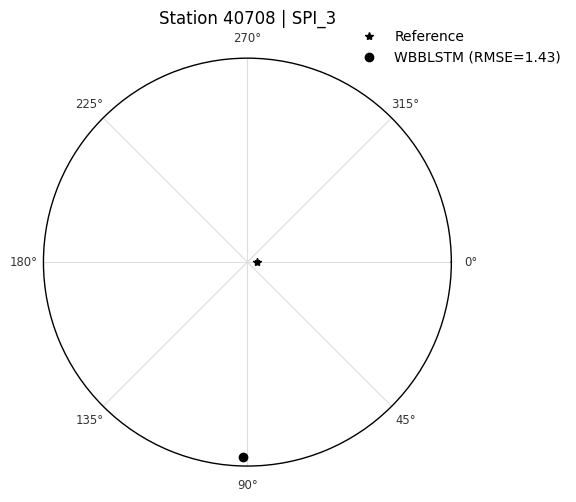

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def taylor_diagram(std_ref, models_stats, title="Taylor Diagram"):
    """
    std_ref : float
        standard deviation of reference.
    models_stats : dict
        { model_name: (std_ref, std_model, corrcoef, rmse) }
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(-1)
    
    # radial limits
    maxstd = max(v[1] for v in models_stats.values()) * 1.1
    ax.set_rmax(maxstd)
    ax.set_rticks(np.linspace(0, maxstd, 4))
    ax.set_rlabel_position(135)
    ax.grid(True)
    
    # plot reference point
    ax.plot(0, std_ref, 'k*', label='Reference')
    
    # plot each model
    for name, (std_o, std_p, corr, rmse) in models_stats.items():
        theta = np.arccos(corr)  # angle from zero
        ax.plot(theta, std_p, 'o', label=f"{name} (RMSE={rmse:.2f})")
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title(title)
    plt.tight_layout()
    plt.show()




for station_id, timescale_dict in results.items():
    for timescale, stats in timescale_dict.items():
        std_ref = next(iter(stats.values()))[0]  # same for every model
        title = f"Station {station_id} | {timescale}"
        taylor_diagram(std_ref, stats, title=title)


In [10]:

from darts import TimeSeries
from darts.models import RNNModel
spi_series = all_spi_data[40708].dropna()

ts = TimeSeries.from_dataframe(spi_series, 'ds', 'SPI_3')

model = RNNModel(
    model='LSTM',
    input_chunk_length=12,    # e.g. use one year of past data
    output_chunk_length=6,    # forecast 6 months at a time
    hidden_dim=25,           # size of hidden layer (try adjusting)
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,             # increase if needed for better convergence
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [11]:
model.fit(ts, verbose=True,)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 86.80it/s, train_loss=0.0566] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 86.05it/s, train_loss=0.0566]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, dropout=0.1, training_length=24, input_chunk_length=12, output_chunk_length=6, batch_size=16, n_epochs=300, optimizer_kwargs={'lr': 0.001}, random_state=42)

Forecasting 309 months into the future.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]


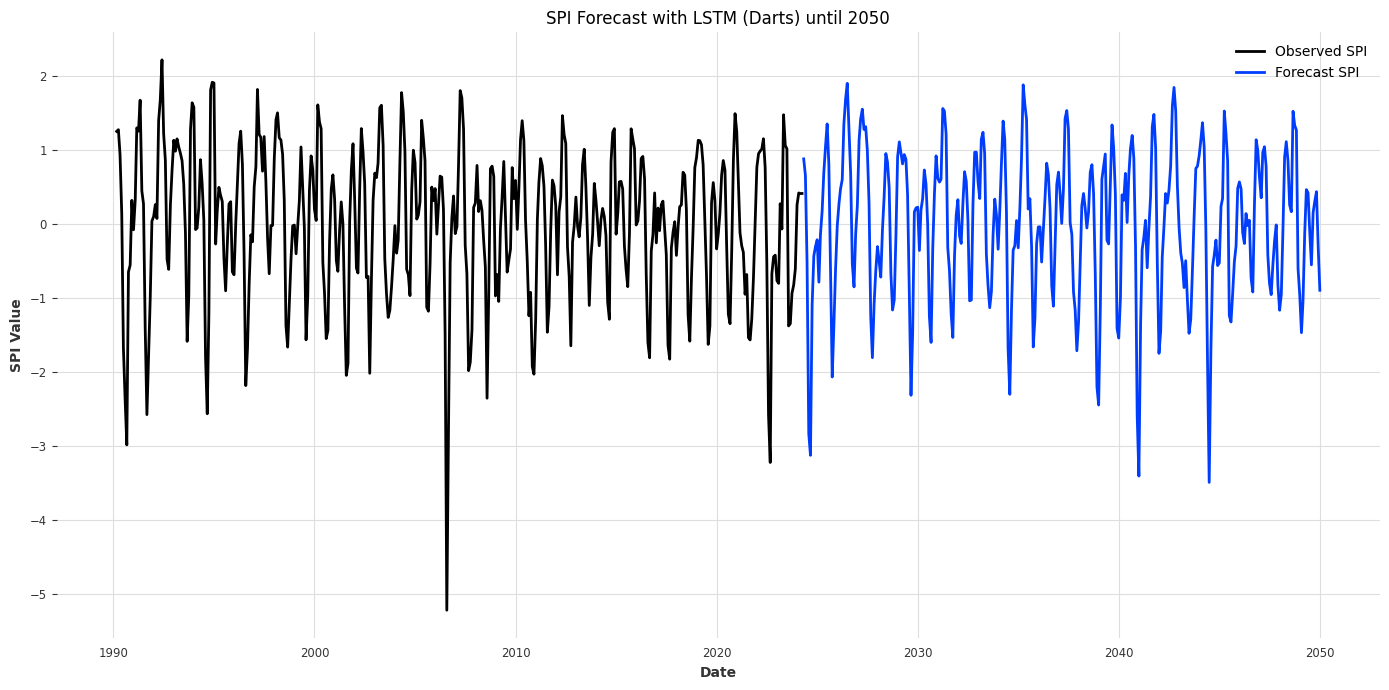

In [12]:
import pandas as pd

# End date of your time series:
last_date = ts.end_time().to_pydatetime()

# Calculate forecast horizon (number of months until January 2050).
# (Assuming you want to forecast up to and including December 2049,
#  so that the new data start from January 2050.)
forecast_steps = (2050 - last_date.year) * 12 - (last_date.month - 1)

print(f"Forecasting {forecast_steps} months into the future.")

import matplotlib.pyplot as plt

# Predict the future SPI until 2050.
forecast = model.predict(n=forecast_steps)

# Plot the original time series and the forecast.
plt.figure(figsize=(14, 7))
ts.plot(label='Observed SPI', lw=2)
forecast.plot(label='Forecast SPI', lw=2)

plt.title("SPI Forecast with LSTM (Darts) until 2050")
plt.xlabel("Date")
plt.ylabel("SPI Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\varas\AppData\Local\Temp\ipykernel_18500\1557287103.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spi_series['year'] = spi_series['ds'].dt.year
C:\Users\varas\AppData\Local\Temp\ipykernel_18500\1557287103.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spi_series['month'] = spi_series['ds'].dt.month


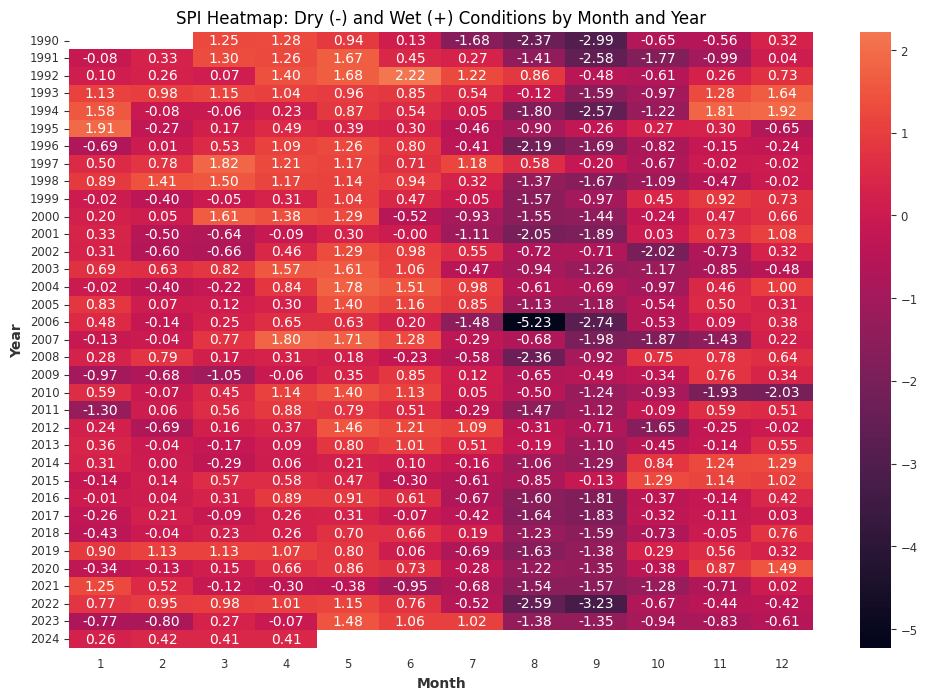

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming ts is a pandas Series with datetime index
# df = ts.to_frame(name='SPI')
spi_series = all_spi_data[40708].dropna()


spi_series['year'] = spi_series['ds'].dt.year
spi_series['month'] = spi_series['ds'].dt.month

# Pivot to heatmap form: each row = year, columns = month
heatmap_data = spi_series.pivot_table(index='year', columns='month', values='SPI_3')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='rocket', center=0, annot=True, fmt=".2f")
plt.title("SPI Heatmap: Dry (-) and Wet (+) Conditions by Month and Year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.grid(False)

plt.show()


C:\Users\varas\AppData\Local\Temp\ipykernel_18500\4029771358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spi_series['category'] = pd.cut(spi_series['SPI_3'], bins=[-np.inf, -1, 1, np.inf], labels=['Dry', 'Normal', 'Wet'])


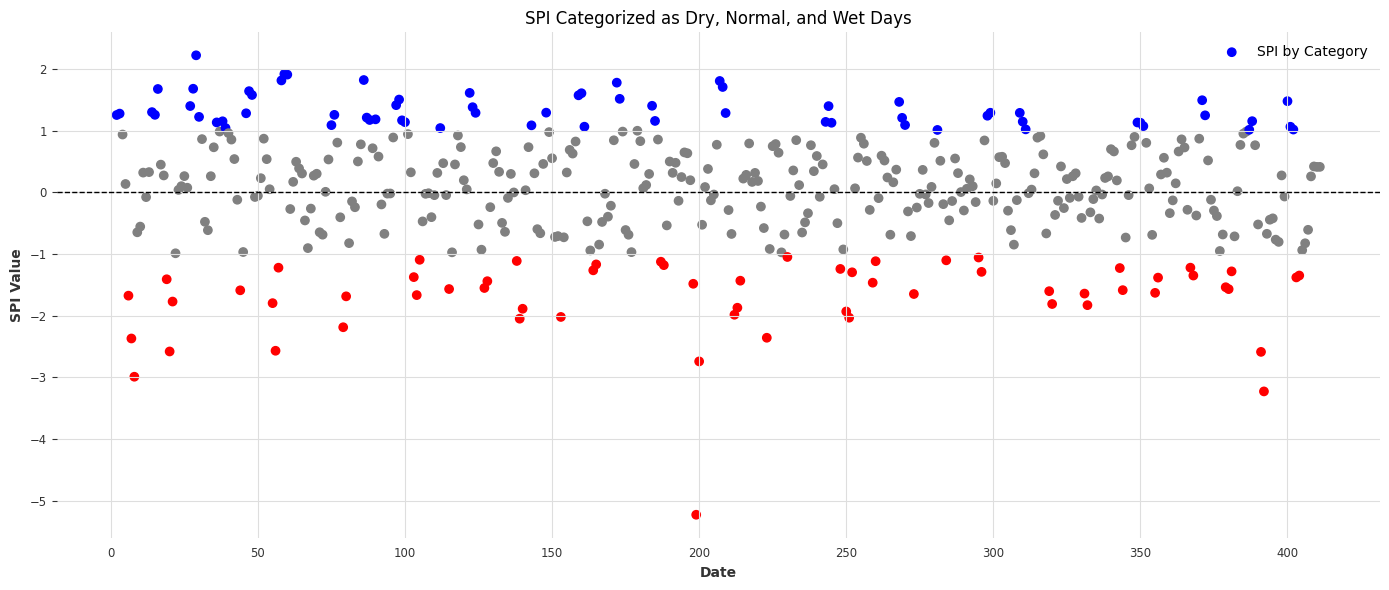

In [21]:
spi_series['category'] = pd.cut(spi_series['SPI_3'], bins=[-np.inf, -1, 1, np.inf], labels=['Dry', 'Normal', 'Wet'])

colors = {'Dry': 'red', 'Normal': 'gray', 'Wet': 'blue'}

plt.figure(figsize=(14, 6))
plt.scatter(spi_series.index, spi_series['SPI_3'], c=spi_series['category'].map(colors), label='SPI by Category')
plt.axhline(0, color='black', lw=1, linestyle='--')
plt.title("SPI Categorized as Dry, Normal, and Wet Days")
plt.xlabel("Date")
plt.ylabel("SPI Value")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
